In [1]:
import csv
import pandas as pd
import csv
import re 
import string
import preprocessor as p
import tweepy
import time
import ast
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def extract_tweets():
    auth = tweepy.OAuthHandler('6Xi8Knl9BHcRzUI8MNyBT8hCi', 'VAfHondef5TU7qHeVNu0Ep9syhMYtBNfEYw4TP0h9Gy83ssMiq') 
    auth.set_access_token('4864487422-53odciu8fwDdc5REbKFCWq2SDCbSaXCleOjMEZQ', '2tomnhO8iUTTbj3wlESgXzhFR596EQoLOgunKDBsr9xSn')
    api = tweepy.API(auth)
    search_words = "jobs"      #enter your words
    new_search = search_words + " -filter:retweets"
    csvFile = open('jobs1.csv', 'a')
    csvWriter = csv.writer(csvFile)
    for tweet in tweepy.Cursor(api.search,q=new_search,tweet_mode='extended',count=100,
                           lang="en",
                           since_id=0).items():
        csvWriter.writerow([tweet.created_at, tweet.full_text.encode('utf-8'),tweet.user.screen_name.encode('utf-8'),
                        tweet.favorite_count,tweet.retweet_count,tweet.truncated,
                        tweet.user.location.encode('utf-8')])
    return

In [2]:
def read_data():
    df=pd.DataFrame()
    df=pd.read_csv('jobsQuestsFinals6.csv')
    df.head()
    return df

In [3]:
def pre_processing(df):
    df.columns=['Date','Tweet','Name','Likes','Retweet','Truncated','Location']
    df['Tweet']=df['Tweet'].apply(lambda x:ast.literal_eval(x).decode('utf-8'))
    df['Location']=df['Location'].apply(lambda x:ast.literal_eval(x).decode('utf-8'))
    df['Name']=df['Name'].apply(lambda x:ast.literal_eval(x).decode('utf-8'))
    df.drop(['Truncated'],inplace=True,axis=1)
    return df

In [4]:
def assorted_tweets(df):
    location=['Atlanta, GA','Washington, DC','Los Angeles, CA','New York, NY', 'Chicago, IL','California, USA','Houston, TX',
          'San Francisco, CA','New Jersey, USA','Boston, MA','Raleigh, NC','Nashville, TN','Seattle, WA','Pittsburgh, PA',
          'Austin, TX','Dallas, TX','California','Portland, OR','Texas','Toronto','Phoenix, AZ','New York, USA',
          'Toronto, Ontario','Texas, USA','Philadelphia, PA','Denver, CO','New York','Florida, USA','Manchester & San Francisco',
          'Charlotte, NC','Las Vegas, NV','Cleveland, OH','Florida','Pennsylvania, USA','Maryland, USA','Louisville, KY',
          'San Antonio, TX','Brooklyn, NY','Orlando, FL','Washington, D.C.','Miami, FL','Lagos, Nigeria','San Diego, CA',
          'Detroit, MI','Colorado, USA','Michigan','Columbus, OH','Los Angeles','Sacramento, CA','New Jersey','Winchester, VA',
          'Baltimore, MD','Pennsylvania','Providence, RI','Indianapolis, IN','North Carolina','Virginia, USA','Indiana',
          'Colorado','Illinois, USA','St. Paul, MN','Buffalo, NY','North Carolina, USA','Calgary, Alberta']          
    df_new= df[df['Location'].isin(location)]
    df_new.reset_index(inplace=True)
    df_new.drop(['index'],inplace=True,axis=1)
    return df_new

In [5]:
def view_data():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    return

In [6]:
def mention_data(df_new):
    mention=[]
    for i in df_new['Tweet']:
        txt=i
        x = re.findall("@", txt)
        mention.append(x)
    df_new['Mentions']=mention
    df_new['len']=df_new['Mentions'].map(lambda x: len(x))
    mentions['Total']=df_new['len'].groupby(df_new['Location']).sum()
    df_new.drop(['Mentions'],inplace=True,axis=1)
    return df_new,mentions

In [7]:
def clean_tweets(df_new):
    stop = stopwords.words('english')
    df_new['Tweet'] = df_new['Tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    df_new['Tweet']=df_new['Tweet'].apply(lambda x: str(x).split('http')[0])
    for i in range(len(df_new['Tweet'])):
        v = df_new['Tweet'][i]
        v = re.sub(r"@[A-Za-z0-9]+", "", v)
        df_new['Tweet'][i]=v
    return df_new

In [8]:
def create_wordcloud(df_new):
    words=''.join(list(df_new['Tweet']))
    spam_wc=WordCloud(width=512,height=512).generate(words)
    plt.figure(figsize=(8,6),facecolor='k')
    plt.imshow(spam_wc)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig('wordcloud.png')
    plt.show()
    return

In [9]:
def sentiment_analysis(df_new):
    sentiment=[]
    Type=[]
    polarity=0
    for i in df_new['Tweet']:
        sentiments=TextBlob(i)
        sentiment.append(sentiments)
        tweet_polarity=sentiments.polarity
        if tweet_polarity>0.00:
            Type.append('Positive')
        elif tweet_polarity<0.00:
            Type.append('Negative')
        elif tweet_polarity==0.00:
            Type.append('Neutral')
        polarity+=tweet_polarity
    df_new['Sentiment']=Type
    return df_new

In [10]:
def recruiter_recruitee(df_new):
    df_recruitee = df_new[df_new['Tweet'].str.contains('need')|df_new['Tweet'].str.contains('want work')|
                      df_new['Tweet'].str.contains('help')|df_new['Tweet'].str.contains('new job')|
                      df_new['Tweet'].str.contains('looking')|df_new['Tweet'].str.contains('support')]
    df_recruitee.drop_duplicates(inplace=True)
    df_recruiter = df_new[df_new['Tweet'].str.contains('link bio')|df_new['Tweet'].str.contains('hiring')|
                      df_new['Tweet'].str.contains('looking')|df_new['Tweet'].str.contains('job opening')|
                      df_new['Tweet'].str.contains('recommend')]
    df_recruitee.drop_duplicates(inplace=True)
    return df_recruitee,df_recruiter

In [11]:
if __name__ == '__main__':
    #extract_tweets()
    view_data()
    df=read_data()
    df=pre_processing(df)
    df_new=assorted_tweets(df)
    mentions=pd.DataFrame()
    df_new,mentions=mention_data(df_new)
    df_new=clean_tweets(df_new)
    df_new=sentiment_analysis(df_new)
    df_recruitee,df_recruiter=recruiter_recruitee(df_new)

C:\Users\saiya\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\saiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\saiya\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

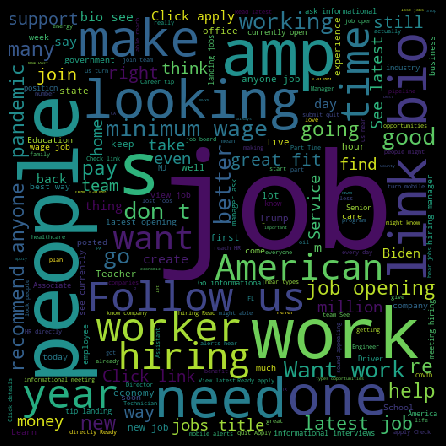

In [12]:
if __name__ == '__main__':
    create_wordcloud(df_new)

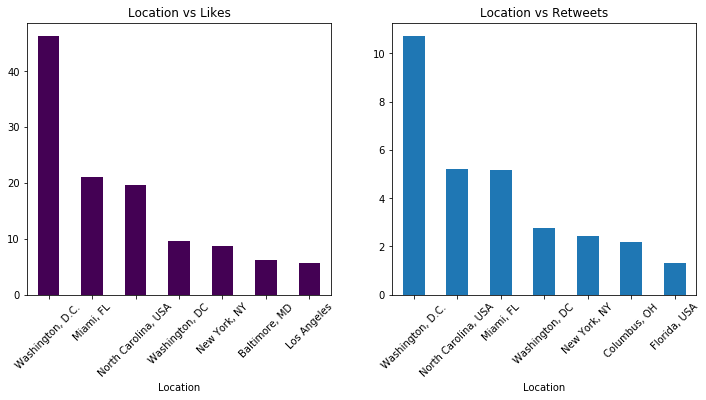

In [37]:
plt.subplot(121)
plt.title('Location vs Likes')
df1=df_new['Likes'].groupby(df_new['Location']).mean().sort_values(ascending=False).head(7)
df1.plot(kind='bar',colormap='viridis',figsize=(7,5))
plt.xticks(rotation=45) 
plt.subplot(122)
plt.title('Location vs Retweets')
df2=df_new['Retweet'].groupby(df_new['Location']).mean().sort_values(ascending=False).head(7)
df2.plot(kind='bar',figsize=(12,5))
plt.xticks(rotation=45) 
plt.savefig('location.png',bbox_inches='tight')
plt.show()

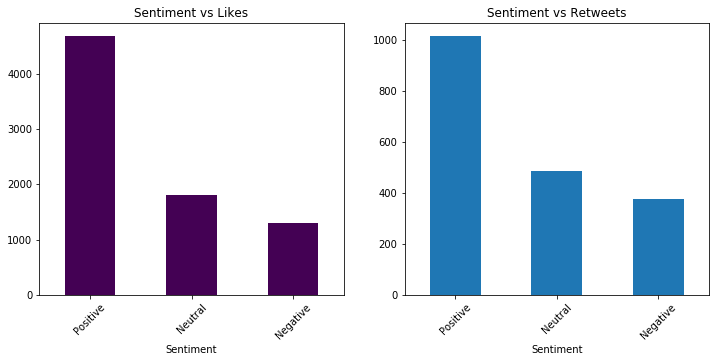

In [31]:
plt.subplot(121)
plt.title('Sentiment vs Likes')
df1=df_new['Likes'].groupby(df_new['Sentiment']).sum().sort_values(ascending=False).head(7)
df1.plot(kind='bar',colormap='viridis',figsize=(7,5))
plt.xticks(rotation=45) 
plt.subplot(122)
plt.title('Sentiment vs Retweets')
df2=df_new['Retweet'].groupby(df_new['Sentiment']).sum().sort_values(ascending=False).head(7)
df2.plot(kind='bar',figsize=(12,5))
plt.xticks(rotation=45) 
plt.savefig('sentiment_sum.png',bbox_inches='tight')
plt.show()

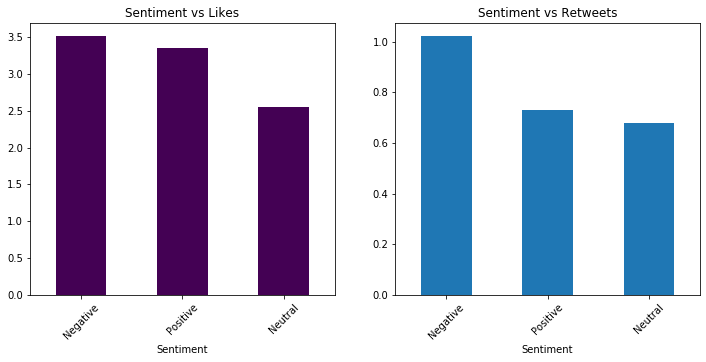

In [34]:
plt.subplot(121)
plt.title('Sentiment vs Likes')
df1=df_new['Likes'].groupby(df_new['Sentiment']).mean().sort_values(ascending=False).head(7)
df1.plot(kind='bar',colormap='viridis',figsize=(7,5))
plt.xticks(rotation=45) 
plt.subplot(122)
plt.title('Sentiment vs Retweets')
df2=df_new['Retweet'].groupby(df_new['Sentiment']).mean().sort_values(ascending=False).head(7)
df2.plot(kind='bar',figsize=(12,5))
plt.xticks(rotation=45) 
plt.savefig('Sentiment_mean.jpeg',bbox_inches='tight')
plt.show()

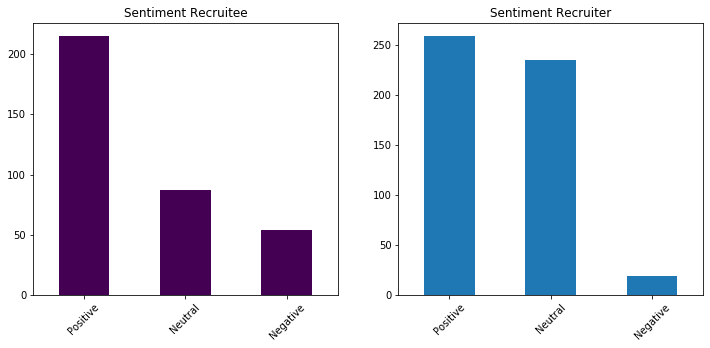

In [33]:
plt.subplot(121)
plt.title('Sentiment Recruitee')
df1=df_recruitee['Sentiment'].value_counts()
df1.plot(kind='bar',colormap='viridis',figsize=(7,5))
plt.xticks(rotation=45) 
plt.subplot(122)
plt.title('Sentiment Recruiter')
df2=df_recruiter['Sentiment'].value_counts()
df2.plot(kind='bar',figsize=(12,5))
plt.xticks(rotation=45) 
plt.savefig('sentiment jobs.png',bbox_inches='tight')
plt.show()

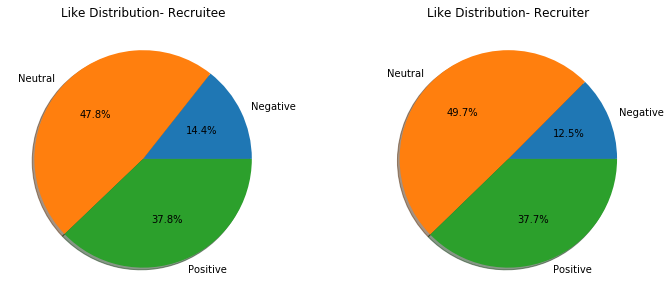

In [41]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Like Distribution- Recruitee')
df1=df_recruitee['Likes'].groupby(df_new['Sentiment']).mean()
plt.pie(df1,labels=df1.index,autopct='%1.1f%%',shadow=True)
plt.subplot(122)
plt.title('Like Distribution- Recruiter')
df2=df_recruiter['Likes'].groupby(df_new['Sentiment']).mean()
plt.pie(df2,labels=df2.index,autopct='%1.1f%%',shadow=True)
plt.savefig('like distribution.png',bbox_inches='tight')
plt.show()

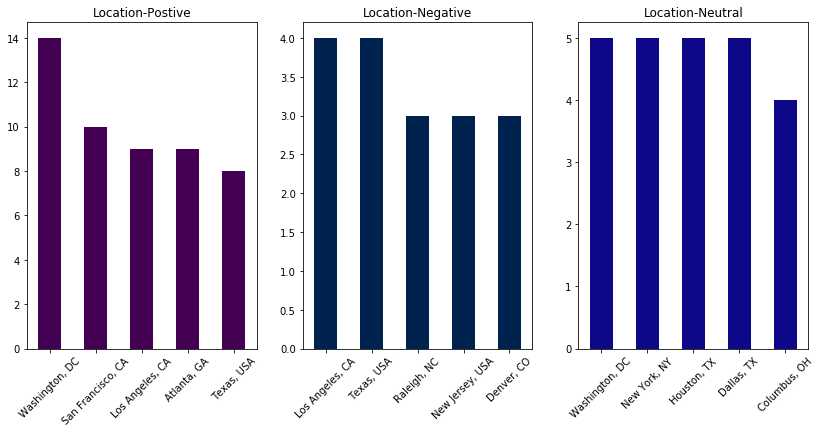

In [35]:
plt.subplot(131)
plt.title('Location-Postive')
a=df_recruitee[df_recruitee['Sentiment']=='Positive']['Location'].value_counts().head(5)
a.plot(kind='bar',colormap='viridis',figsize=(14,6))
plt.xticks(rotation=45)
plt.subplot(132)
plt.title('Location-Negative')
b=df_recruitee[df_recruitee['Sentiment']=='Negative']['Location'].value_counts().head(5)
b.plot(kind='bar',colormap='cividis',figsize=(14,6))
plt.xticks(rotation=45) 
plt.subplot(133)
plt.title('Location-Neutral')
b=df_recruitee[df_recruitee['Sentiment']=='Neutral']['Location'].value_counts().head(5)
b.plot(kind='bar',colormap='plasma',figsize=(14,6))
plt.xticks(rotation=45)
plt.savefig('Sentiment location segregation.png',bbox_inches='tight')
plt.show()

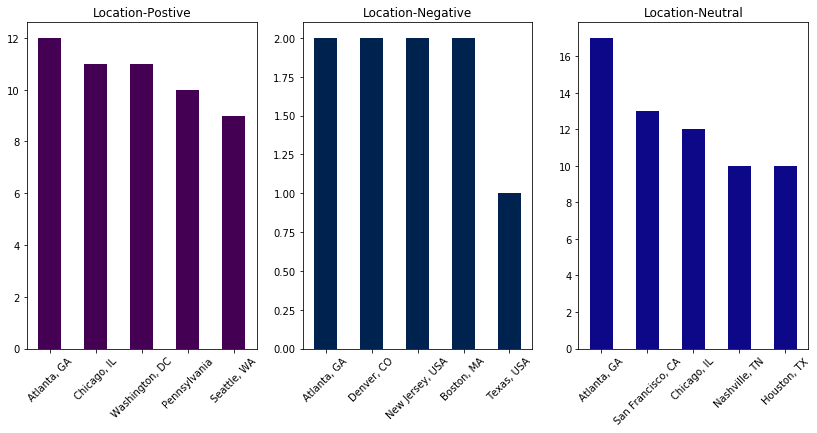

In [36]:
plt.subplot(131)
plt.title('Location-Postive')
a=df_recruiter[df_recruiter['Sentiment']=='Positive']['Location'].value_counts().head(5)
a.plot(kind='bar',colormap='viridis',figsize=(14,6))
plt.xticks(rotation=45)
plt.subplot(132)
plt.title('Location-Negative')
b=df_recruiter[df_recruiter['Sentiment']=='Negative']['Location'].value_counts().head(5)
b.plot(kind='bar',colormap='cividis',figsize=(14,6))
plt.xticks(rotation=45) 
plt.subplot(133)
plt.title('Location-Neutral')
b=df_recruiter[df_recruiter['Sentiment']=='Neutral']['Location'].value_counts().head(5)
b.plot(kind='bar',colormap='plasma',figsize=(14,6))
plt.xticks(rotation=45)
plt.savefig('Sentiment location segregation2.png',bbox_inches='tight')
plt.show()

In [77]:
mentions.reset_index().sort_values(by='Total',ascending=False).head(7)

,Location,Total
27,"Los Angeles, CA",118
0,"Atlanta, GA",116
62,"Washington, DC",102
57,"Texas, USA",97
8,"California, USA",92
37,"New York, NY",82
10,"Chicago, IL",56


In [80]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
geopy
give them the place name, theyll give lat and long
put it in geopandas
they will mark in the map

In [50]:
len(df_recruiter[df_recruiter['Sentiment']=='Negative'])

19

In [52]:
b=df_recruiter[df_recruiter['Sentiment']=='Negative']['Location'].value_counts()

In [53]:
b

Atlanta, GA        2
Denver, CO         2
New Jersey, USA    2
Boston, MA         2
Texas, USA         1
Portland, OR       1
Orlando, FL        1
California         1
Maryland, USA      1
Pennsylvania       1
Las Vegas, NV      1
Los Angeles, CA    1
Colorado, USA      1
Texas              1
Dallas, TX         1
Name: Location, dtype: int64

In [ ]:
b.plot(kind='bar',colormap='cividis',figsize=(14,6))

In [1]:
import re
v = '$45,$55,$63,$54,$5'
v=v.replace(',',':')
l=v.split(':')
print(l)

['$45', '$55', '$63', '$54', '$5']


In [25]:
type(v)

str

In [ ]:
v = df_new['Tweet'][i]
        v = re.sub(r"@[A-Za-z0-9]+", "", v)
        df_new['Tweet'][i]=v